In [1]:
import os
import math
import random
import copy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter, defaultdict
from itertools import chain, combinations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from typing import Optional
import matplotlib.cm as cm

In [2]:
from Nash import find_nash_equilibria_v2
from Functions import compute_and_visualize_shapley_values

In [3]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
def aggregate_lr_models(models: list):
    aggregated_model = LogisticRegression()
    aggregated_model.coef_ = np.mean([model.coef_ for model in models], axis=0)
    noise = np.random.normal(0, 0.05, aggregated_model.coef_.shape)
    aggregated_model.coef_ += noise
    aggregated_model.intercept_ = np.mean([model.intercept_ for model in models], axis=0)
    aggregated_model.classes_ = models[0].classes_
    return aggregated_model

In [5]:
file_path = '/Users/abbaszal/Documents/Thesis_Project_Spambase/data/spambase.data'  # Adjust the path as needed
df = pd.read_csv(file_path, header=None)

In [6]:
# PRNG seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
def split_data_equal(X: np.ndarray, y: np.ndarray, n_clients: int, shuffle: bool=False, random_seed: int = None):
    if shuffle:
        if random_seed is not None:
            np.random.seed(random_seed)
        idx = np.random.permutation(X.shape[0])
        X = X[idx]
        y = y[idx]

    n_entries_per_client = X.shape[0] // n_clients
    partitions = []
    for i in range(n_clients):
        start = i * n_entries_per_client
        end = (i + 1) * n_entries_per_client
        X_i = X[start:end]
        y_i = y[start:end]
        partitions.append((X_i, y_i))
    # Ensure the last partition gets all remaining data.
    partitions[-1] = (X[start:], y[start:])

    return partitions


In [8]:
def corrupt_data(X: np.ndarray, y: np.ndarray, corruption_prob: float = 0.8, nan_prob: float = 0.5, noise_std: Optional[float] = None):
    if noise_std is None:
        noise_std = 0.1
        
    X = X.copy()

    mask = np.random.rand(X.shape[0]) < corruption_prob
    mask_nan = mask & (np.random.rand(X.shape[0]) < nan_prob)
    mask_noise = mask & (~mask_nan)

    X += mask_noise[:, None] * np.random.randn(X.shape[0], X.shape[1]) * noise_std
    X[np.argwhere(mask_nan)] = np.nan
    
    return X, y



# Function to corrupt data for specific clients, keeping the same corruption indices across trials
def corrupt_clients(f, partitions, corrupt_client_indices):

    for idx in corrupt_client_indices:
        X_i, y_i = partitions[idx]
        X_i_corrupted, y_i_corrupted = f(X_i.copy(), y_i.copy())
        partitions[idx] = (X_i_corrupted, y_i_corrupted)
    
    return partitions, corrupt_client_indices

In [9]:
def train_client_models(partitions, random_seed, X_test, y_test, max_iter):
    client_models = []
    client_global_accuracies = []
    client_local_accuracies = []
    for X_i, y_i in partitions:
        # Remove rows with NaN values
        nan_mask = ~np.isnan(X_i).any(axis=1)
        X_i_clean = X_i[nan_mask]
        y_i_clean = y_i[nan_mask]
        if len(y_i_clean) == 0:
            # No data to train on after cleaning
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
            continue
        model = LogisticRegression(random_state=random_seed, max_iter=max_iter)
        try:
            model.fit(X_i_clean, y_i_clean)
            client_models.append(model)

            acc_local = model.score(X_i_clean, y_i_clean)
            client_local_accuracies.append(acc_local)

            # Compute local accuracy on global test set
            local_acc = model.score(X_test, y_test)
            client_global_accuracies.append(local_acc)

        except Exception as e:
            # Model training failed
            client_models.append(None)
            client_global_accuracies.append(None)
            client_local_accuracies.append(None)
    return client_models, client_local_accuracies, client_global_accuracies

def run_federated_learning(
    partitions_corrupted,  # Precomputed corrupted partitions
    corrupt_client_indices,
    n_clients=10,
    random_seed=None,
    shuffle=True,
    max_iter=10,
):


    # Train models for each client and compute accuracies
    client_models, client_local_accuracies, client_global_accuracies = train_client_models(
        partitions_corrupted, random_seed, X_test, y_test, max_iter
    )

    # Generate all possible combinations of clients represented as binary strings
    results = []
    n_combinations = 2 ** n_clients
    for i in range(1, n_combinations):
        bin_str = format(i, f'0{n_clients}b')
        # Determine which clients are included in this combination
        client_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
        included_models = [client_models[j] for j in client_indices if client_models[j] is not None]

        if not included_models:
            # Skip combinations where no valid models are available
            continue

        # Aggregate models
        federated_model = aggregate_lr_models(included_models)
        agg_acc = federated_model.score(X_test, y_test)

        # Prepare the row data
        row = {'Combination': bin_str, 'Clients': [client + 1 for client in client_indices], 'Global Accuracy': agg_acc}

        # Add global accuracies for each client
        for j in range(n_clients):
            acc = client_global_accuracies[j] if client_global_accuracies[j] is not None else np.nan
            column_name = f"Client {j + 1} Accuracy"
            if j in corrupt_client_indices:
                column_name += " (corrupted client)"
            row[column_name] = acc

        results.append(row)

    df_results = pd.DataFrame(results)

    print(f"Corrupted client indices: {np.array(corrupt_client_indices) + 1}")

    return df_results, corrupt_client_indices, client_local_accuracies, client_global_accuracies



Running experiment for max_iter = 10
  Running trial 1/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 2/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 3/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 4/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 5/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 6/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 7/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 8/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 9/10 for max_iter = 10
Corrupted client indices: [1 2 3]
  Running trial 10/10 for max_iter = 10
Corrupted client indices: [1 2 3]
Nash equilibrium counts saved to /Users/abbaszal/Documents/Thesis_Project_Spambase/Nash_Equilibrium_Counts_maxiter_10.csv

Running experiment for max_iter = 100
  Running trial 1/10 for max_iter = 100
Corrupted client indices: [1 2

/var/folders/hn/l1bxr6v97478sfly3rj76my40000gn/T/ipykernel_14863/3050820774.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('PuRd', len(noise_std_values))


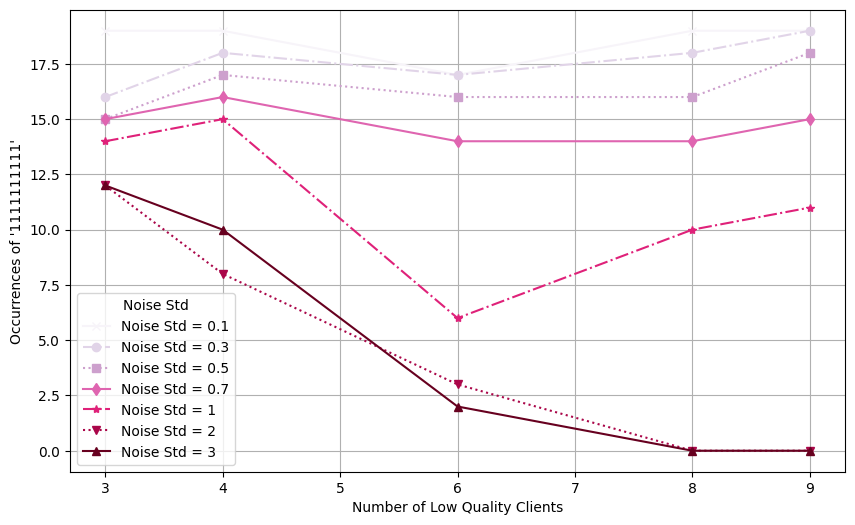

In [27]:
# Modified run_experiment that accepts a custom corruption function
def run_experiment_modified(n_trials, n_clients, max_iters, partitions_corrupted, corrupt_client_indices, df, save_dir, corrupt_function=corrupt_data):
    os.makedirs(save_dir, exist_ok=True)  
    all_nash_details = []

    for max_iter in max_iters:
        print(f"\nRunning experiment for max_iter = {max_iter}")
        nash_counts = Counter()
        details_for_this_max_iter = []

        # Fix corruption indices across trials if not provided
        if corrupt_client_indices is None or len(corrupt_client_indices) == 0:
            corrupt_client_indices = np.random.choice(n_clients, size=partitions_corrupted, replace=False)

        for trial in range(n_trials):
            print(f"  Running trial {trial + 1}/{n_trials} for max_iter = {max_iter}")

            base_random_seed = 42
            trial_seed = base_random_seed + trial + max_iter
            random.seed(trial_seed)
            np.random.seed(trial_seed)

            # Split and prepare data
            X = df.iloc[:, :-1].to_numpy()
            y = df.iloc[:, -1].to_numpy()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial_seed)

            # Normalize data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Split data into client partitions
            partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True, random_seed=trial_seed)
            
            # Apply corruption using fixed corrupt client indices and the provided corruption function
            corrupted_partitions, _ = corrupt_clients(corrupt_function, partitions, corrupt_client_indices)

            # Run federated learning with the corrupted partitions
            df_results, _, client_local_accuracies, client_global_accuracies = run_federated_learning(
                partitions_corrupted=corrupted_partitions,
                corrupt_client_indices=corrupt_client_indices,
                n_clients=n_clients,
                random_seed=trial_seed,
                max_iter=max_iter,
            )

            # Find Nash equilibria
            df_nash = find_nash_equilibria_v2(df_results)

            # Count Nash equilibrium occurrences
            for coalition in df_nash['Combination']:
                nash_counts[coalition] += 1

            details_for_this_max_iter.append(df_nash)

        # Optionally save counts per max_iter
        df_nash_counts = pd.DataFrame(nash_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
        df_nash_counts['Max Iter'] = max_iter
        counts_filename = os.path.join(save_dir, f"Nash_Equilibrium_Counts_maxiter_{max_iter}.csv")
        df_nash_counts.to_csv(counts_filename, index=False)
        print(f"Nash equilibrium counts saved to {counts_filename}")

        df_details = pd.concat(details_for_this_max_iter, ignore_index=True)
        all_nash_details.append(df_details)

    final_details_df = pd.concat(all_nash_details, ignore_index=True)
    details_path = os.path.join(save_dir, "Nash_Equilibrium_Details.csv")
    final_details_df.to_csv(details_path, index=False)
    print(f"Nash equilibrium details saved to {details_path}")
    
    return final_details_df

# --- Parameters for the experiment ---
noise_std_values = [0.1, 0.3, 0.5, 0.7, 1,2, 3]
corrupted_clients_counts = [3,4, 6, 8, 9]        
n_trials = 10
n_clients = 10
max_iters = [10,100]  
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase"


# Dictionary to store results: for each noise_std, store a list of occurrence counts indexed by number of bad clients.
results = {noise: [] for noise in noise_std_values}

for noise in noise_std_values:
    for cc in corrupted_clients_counts:
        client_indices = list(range(cc))
        custom_corrupt_data = lambda X, y, corruption_prob=0.8, nan_prob=0.5, noise_std_local=noise: corrupt_data(X, y, corruption_prob, nan_prob, noise_std_local)
        
        final_details_df = run_experiment_modified(
            n_trials=n_trials,
            n_clients=n_clients,
            max_iters=max_iters,
            partitions_corrupted=cc,          
            corrupt_client_indices=client_indices,      
            df=df,
            save_dir=save_dir,
            corrupt_function=custom_corrupt_data
        )
        
        # Count occurrences of the Nash equilibrium "1111111111"
        occurrence_count = (final_details_df['Combination'] == '1111111111').sum()
        results[noise].append(occurrence_count)
        print(f"Noise Std: {noise}, Bad Clients: {cc}, Occurrences: {occurrence_count}")

results_df = pd.DataFrame(results, index=corrupted_clients_counts)
results_df.index.name = "Number of Bad Clients"
results_csv_path = os.path.join(save_dir, "nash_occurrence_results.csv")
results_df.to_csv(results_csv_path)
print(f"Results saved to {results_csv_path}")


cmap = cm.get_cmap('PuRd', len(noise_std_values))
markers = ['x','o','s','d', '*','v', '^', '<', '>','h', 'D']
linestyles = ['-',  '-.', ':']

plt.figure(figsize=(10, 6))
for i, noise in enumerate(noise_std_values):
    color = cmap(i) 
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    
    plt.plot(corrupted_clients_counts, results[noise],
             marker=marker, linestyle=linestyle, color=color,
             label=f'Noise Std = {noise}')

plt.xlabel("Number of Low Quality Clients")
plt.ylabel("Occurrences of '1111111111'")
plt.legend(title="Noise Std")
plt.grid(True)
plt.show()



/var/folders/hn/l1bxr6v97478sfly3rj76my40000gn/T/ipykernel_14863/2204300064.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(noise_std_values))


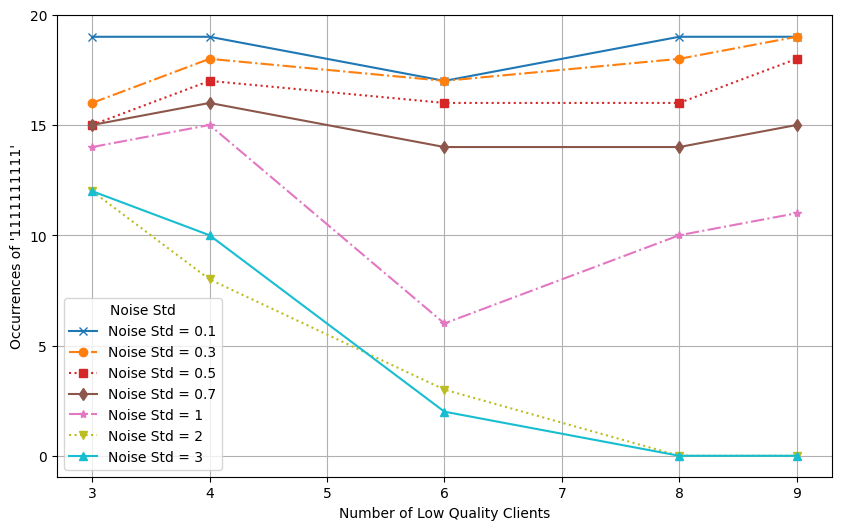

In [34]:
cmap = cm.get_cmap('tab10', len(noise_std_values))
markers = ['x','o','s','d', '*','v', '^', '<', '>','h', 'D']
linestyles = ['-',  '-.', ':']

plt.figure(figsize=(10, 6))
for i, noise in enumerate(noise_std_values):
    color = cmap(i) 
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    
    plt.plot(corrupted_clients_counts, results[noise],
             marker=marker, linestyle=linestyle, color=color,
             label=f'Noise Std = {noise}')

plt.xlabel("Number of Low Quality Clients")
plt.ylabel("Occurrences of '1111111111'")
plt.legend(title="Noise Std")
# Set y-axis to only show integer values
y_min, y_max = plt.ylim()
plt.yticks(np.arange(np.ceil(y_min), np.floor(y_max) + 5, 5))
plt.grid(True)
plt.show()


### FL

In [23]:
# Define the DecisionTree class
class DecisionTree:
    def __init__(self, max_depth=None, random_state=None):
        self.max_depth = max_depth
        self.tree_ = None
        self.random_state = random_state

    def fit(self, X, y):
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
        self.tree_.fit(X, y)

    def predict(self, X):
        return self.tree_.predict(X)

# Define the FederatedForest class
class FederatedForest:
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        predictions = np.array(predictions).T
        y = [np.bincount(row).argmax() for row in predictions]
        return np.array(y)
    

Noise Std: 0.1, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 0.1, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 0.1, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 20


Noise Std: 0.1, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 20


Noise Std: 0.1, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 20


Noise Std: 0.3, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 0.3, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 0.3, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 20


Noise Std: 0.3, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 20


Noise Std: 0.3, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 20


Noise Std: 0.5, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 0.5, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 0.5, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 20


Noise Std: 0.5, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 20


Noise Std: 0.5, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 20


Noise Std: 0.7, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 0.7, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 0.7, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 19


Noise Std: 0.7, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 18


Noise Std: 0.7, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 18


Noise Std: 1, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 1, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 1, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 20


Noise Std: 1, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 17


Noise Std: 1, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 17


Noise Std: 2, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 2, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 2, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 20


Noise Std: 2, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 19


Noise Std: 2, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 19


Noise Std: 3, Corrupted Clients: [0, 1, 2], Occurrences: 20


Noise Std: 3, Corrupted Clients: [0, 1, 2, 3], Occurrences: 20


Noise Std: 3, Corrupted Clients: [0, 1, 2, 3, 4, 5], Occurrences: 19


Noise Std: 3, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7], Occurrences: 20


/var/folders/hn/l1bxr6v97478sfly3rj76my40000gn/T/ipykernel_14863/3548008992.py:161: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(noise_std_values))


Noise Std: 3, Corrupted Clients: [0, 1, 2, 3, 4, 5, 6, 7, 8], Occurrences: 17
Results saved to /Users/abbaszal/Documents/Thesis_Project_Spambase/nash_occurrence_results_run_experiment_2.csv


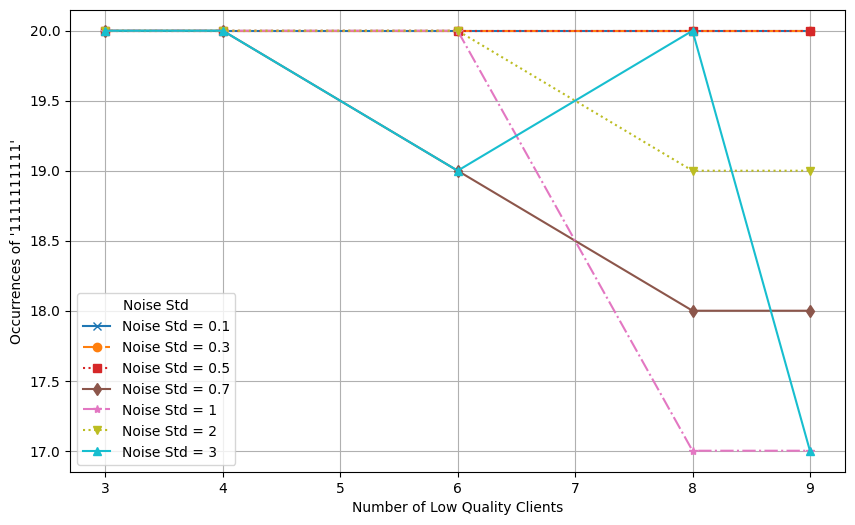

In [26]:
def run_experiment_2_modified(n_trials, n_clients, max_depths, partitions_corrupted, corrupt_client_indices, df, 
                              save_dir="results", base_random_seed=42, corrupt_function=corrupt_data, verbose=False):
    os.makedirs(save_dir, exist_ok=True)
    all_nash_details = []

    # Loop over provided max_depths. (For plotting, you might use a single value.)
    for max_depth in max_depths:
        if verbose:
            print(f"\nRunning experiment with max_depth = {max_depth}")
        nash_equilibrium_counts = Counter()
        details_for_this_max_depth = []

        # Use provided corrupt_client_indices or select randomly if not given.
        if corrupt_client_indices is None or len(corrupt_client_indices) == 0:
            corrupt_client_indices = list(np.random.choice(n_clients, size=partitions_corrupted, replace=False))

        for trial in range(n_trials):
            if verbose:
                print(f"  Trial {trial + 1}/{n_trials} for max_depth = {max_depth}")
            trial_seed = base_random_seed + trial + max_depth
            random.seed(trial_seed)
            np.random.seed(trial_seed)

            if verbose:
                print(f"    Corrupted client indices: {np.array(corrupt_client_indices) + 1}")

            # Split data (assuming the target is the last column)
            target_column = df.columns[-1]
            X = df.drop(target_column, axis=1).to_numpy()
            y = df[target_column].to_numpy()
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial_seed)

            # Normalize data
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Partition data among clients
            partitions = split_data_equal(X_train, y_train, n_clients=n_clients, shuffle=True, random_seed=trial_seed)

            # Apply corruption using the provided corruption function.
            corrupted_partitions, _ = corrupt_clients(corrupt_function, partitions, corrupt_client_indices)

            # Train a decision tree for each client's (corrupted) data.
            client_models = []
            client_global_accuracies = {}
            for i, (X_i, y_i) in enumerate(corrupted_partitions):
                model = DecisionTreeClassifier(max_depth=max_depth, random_state=np.random.randint(0, 100000))
                model.fit(X_i, y_i)
                client_models.append(model)
                y_pred = model.predict(X_test)
                acc_global = accuracy_score(y_test, y_pred)
                client_global_accuracies[i] = acc_global

            # Evaluate all possible coalitions
            trial_results = []
            n_combinations = 2 ** n_clients
            for i in tqdm(range(1, n_combinations), desc=f"    Evaluating coalitions for trial {trial + 1}", leave=False):
                bin_str = format(i, f'0{n_clients}b')
                coalition_indices = [j for j in range(n_clients) if bin_str[n_clients - 1 - j] == '1']
                included_models = [client_models[j] for j in coalition_indices]
                if not included_models:
                    continue

                # Federated aggregation using a FederatedForest
                forest = FederatedForest()
                for model in included_models:
                    forest.add_model(model)
                y_pred_global = forest.predict(X_test)
                coalition_acc_global = accuracy_score(y_test, y_pred_global)

                row = {
                    'Trial': trial + 1,
                    'Combination': bin_str,
                    'Clients': ",".join(str(j + 1) for j in coalition_indices),
                    'Global Accuracy': coalition_acc_global
                }
                for j in range(n_clients):
                    row[f'Client {j + 1} Accuracy'] = client_global_accuracies.get(j, np.nan)
                trial_results.append(row)

            df_trial_results = pd.DataFrame(trial_results)
            df_trial_results.set_index('Combination', inplace=True)
            # Convert 'Clients' column from comma-separated string to list of ints.
            df_trial_results['Clients'] = df_trial_results['Clients'].apply(
                lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x
            )

            # Find Nash equilibria for this trial.
            nash_df = find_nash_equilibria_v2(df_trial_results.reset_index())
            for combination in nash_df['Combination']:
                nash_equilibrium_counts[combination] += 1

            details_for_this_max_depth.append(nash_df)

        # Save Nash equilibrium counts for the current max_depth.
        df_nash_counts = pd.DataFrame(nash_equilibrium_counts.items(), columns=['Nash Equilibrium', 'Occurrences'])
        df_nash_counts['Max Depth'] = max_depth
        counts_filename = os.path.join(save_dir, f"Nash_Equilibrium_Counts_max_depth_{max_depth}.csv")
        df_nash_counts.to_csv(counts_filename, index=False)
        if verbose:
            print(f"Nash equilibrium counts saved to {counts_filename}")

        df_details = pd.concat(details_for_this_max_depth, ignore_index=True)
        all_nash_details.append(df_details)

    final_details_df = pd.concat(all_nash_details, ignore_index=True)
    details_path = os.path.join(save_dir, "Nash_Equilibrium_Details_run_experiment_2.csv")
    final_details_df.to_csv(details_path, index=False)
    if verbose:
        print(f"Nash equilibrium details saved to {details_path}")
    
    return final_details_df


noise_std_values = [0.1, 0.3, 0.5, 0.7, 1,2, 3]
corrupted_clients_counts = [3, 4, 6, 8, 9] 
n_trials = 10
n_clients = 10
max_depths = [10, 100]    
save_dir = "/Users/abbaszal/Documents/Thesis_Project_Spambase"

results = {noise: [] for noise in noise_std_values}

# Loop over each noise_std value and each number of corrupted clients.
for noise in noise_std_values:
    for cc in corrupted_clients_counts:
        # For cc corrupted clients, manually set the indices as [0, 1, ..., cc-1]
        client_indices = list(range(cc))
        # Create a custom corruption function that sets noise_std to the current value.
        custom_corrupt_data = lambda X, y, corruption_prob=0.8, nan_prob=0.5, noise_std_local=noise: \
            corrupt_data(X, y, corruption_prob, nan_prob, noise_std_local)
        
        # Run experiment_2_modified with the current noise_std and client indices.
        final_details_df = run_experiment_2_modified(
            n_trials=n_trials,
            n_clients=n_clients,
            max_depths=max_depths,
            partitions_corrupted=cc,
            corrupt_client_indices=client_indices,
            df=df,
            save_dir=save_dir,
            base_random_seed=42,
            corrupt_function=custom_corrupt_data,
            verbose=False  
        )
        
        # Count occurrences of the Nash equilibrium "1111111111"
        occurrence_count = (final_details_df['Combination'] == '1111111111').sum()
        results[noise].append(occurrence_count)
        print(f"Noise Std: {noise}, Corrupted Clients: {client_indices}, Occurrences: {occurrence_count}")


results_df = pd.DataFrame(results, index=corrupted_clients_counts)
results_df.index.name = "Number of Bad Clients"
results_csv_path = os.path.join(save_dir, "nash_occurrence_results_run_experiment_2.csv")
results_df.to_csv(results_csv_path)
print(f"Results saved to {results_csv_path}")


cmap = cm.get_cmap('tab10', len(noise_std_values))
markers = ['x', 'o', 's', 'd', '*', 'v', '^', '<', '>', 'h', 'D']
linestyles = ['-', '-.', ':']

plt.figure(figsize=(10, 6))
for i, noise in enumerate(noise_std_values):
    color = cmap(i)
    marker = markers[i % len(markers)]
    linestyle = linestyles[i % len(linestyles)]
    
    plt.plot(corrupted_clients_counts, results[noise],
             marker=marker, linestyle=linestyle, color=color,
             label=f'Noise Std = {noise}')

plt.xlabel("Number of Low Quality Clients")
plt.ylabel("Occurrences of '1111111111'")
plt.legend(title="Noise Std")
plt.grid(True)
plt.show()
